## Chloropleth for SICRU model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import numpy as np

import matplotlib

### get table 

In [2]:
tbpath = "../../fits/"

In [3]:
df = pd.read_csv(tbpath + "fit_table_reweighted.csv") #get rois in all tables (some may have failed)
rois = list(df.roi.unique())
rois = list(set(rois))

roi_us = np.sort([i for i in rois if i[:2]=='US'])[::-1]
roi_other = np.sort([i for i in rois if i[:2]!='US'])[::-1]
rois = list(roi_us) + list(roi_other)

In [4]:
statehash = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [5]:
theta = 'R0'

Text(0.5, 1.0, 'R0')

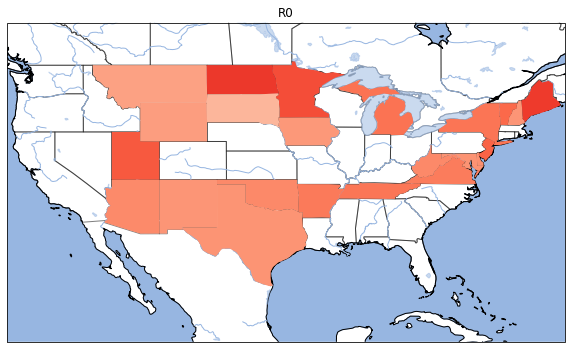

In [56]:

cmap = matplotlib.cm.get_cmap('Reds')

maptype = ccrs.PlateCarree()

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_1_states_provinces_lakes_shp')

reader = shpreader.Reader(shpfilename)
states = reader.records()
# state = next(states)
# print(state.attributes.keys())

f,ax = plt.subplots(1,2,figsize=(10,30))
ax = plt.axes(projection=maptype)
# ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES, linestyle='-', alpha=.5)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# print(dir(cartopy.feature))
for state in states:
    st = (state.attributes['name_alt']).split("|")[0]
    roi = 'US_'+st
    try:
        c = 0.1*df.loc[(df.roi==roi)&(df['quantile']=='0.5'), theta].values[0]
#         print(c)
        if state.geometry.type == 'Polygon':
            state_geo = [state.geometry]
        else:
            state_geo = state.geometry
        ax.add_geometries(state_geo, maptype, facecolor=cmap(c))
    except:
        pass

ax.set_title('R0')       
# ## https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629        
# sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=plt.Normalize(vmin=0, vmax=1))
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax)
# # cax = divider.append_axes("right", size="5%", pad=0.05)
# print(divider)
# # plt.colorbar(sm,cax=cax)   

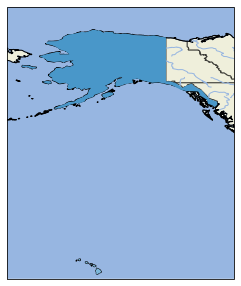

In [19]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax = plt.axes(projection=maptype)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES, linestyle='-', alpha=.5)
ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([1.4*-125, 1.9*-66.5, 0.9*20, 1.5*50], ccrs.Geodetic())
# print(dir(cartopy.feature))
states = reader.records()
for state in states:
    st = (state.attributes['name_alt']).split("|")[0]
    roi = 'US_'+st
    try:
        c = 0.05*df.loc[(df.roi==roi)&(df['quantile']=='0.975'), theta].values[0]
#         print(c)
        if state.geometry.type == 'Polygon':
            state_geo = [state.geometry]
        else:
            state_geo = state.geometry
        ax.add_geometries(state_geo, maptype, facecolor=cmap(c))
    except:
        print()
    